In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
plt.style.use("ggplot")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/12_face_pose_merged/ekman/openface_plus_openpose_inner_without_NaN_success0.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
0,0,0,1,0,0.00,0.98,1,0.217484,0.400964,-0.889904,0.050022,0.410571,-0.910455,0.148,0.423,688.7,689.9,694.0,698.6,700.9,700.0,695.6,691.1,681.6,684.7,688.8,693.5,698.2,701.8,704.6,702.1,698.2,693.6,689.1,684.9,693.1,695.0,696.8,697.3,696.3,...,0.010681,226.892,739.838,0.01007,266.036,722.223,0.017656,254.293,716.352,0.010845,235.699,739.838,0.008400,229.828,739.838,0.008405,261.143,721.245,0.024683,254.293,716.352,0.012333,248.421,756.474,0.011577,242.550,759.410,0.009841,258.207,710.480,0.022670,253.314,725.159,0.014937,238.635,743.753,0.014931,236.678,745.710,0.011006
1,1,1,2,0,0.04,0.98,1,0.223496,0.397311,-0.890052,0.019622,0.406862,-0.913279,0.134,0.419,687.7,689.0,693.2,697.8,700.2,699.1,694.7,690.1,680.3,683.5,687.7,692.6,697.4,701.1,703.7,701.2,697.3,692.7,688.0,683.7,692.1,694.1,695.9,696.5,695.5,...,0.009651,297.901,804.716,0.00743,347.284,736.185,0.018372,360.385,710.990,0.007789,316.042,793.630,0.007539,297.901,801.693,0.006193,338.213,738.201,0.026940,360.385,710.990,0.009862,316.042,785.568,0.010101,303.948,791.615,0.006913,338.213,740.216,0.030672,337.205,739.209,0.013722,315.034,781.536,0.009954,307.979,783.552,0.007570
2,2,2,3,0,0.08,0.98,1,0.220156,0.372378,-0.901591,0.014346,0.395123,-0.918516,0.128,0.399,686.9,688.3,692.5,697.1,699.3,698.2,693.7,689.1,679.7,682.8,686.9,691.8,696.6,700.3,703.0,700.3,696.4,691.7,687.2,683.0,691.3,693.2,695.1,695.7,694.7,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
3,3,3,4,0,0.12,0.98,1,0.232741,0.351699,-0.906719,0.029666,0.370821,-0.928231,0.142,0.375,684.7,686.3,690.5,695.0,697.1,695.8,691.3,686.8,677.4,680.6,684.8,689.6,694.4,698.0,700.6,697.9,694.0,689.5,684.9,680.7,689.0,690.9,692.8,693.4,692.5,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
4,4,4,5,0,0.16,0.98,1,0.220415,0.332130,-0.917119,0.030642,0.365490,-0.930311,0.135,0.361,682.3,683.9,688.2,692.6,694.6,693.3,688.7,684.3,675.2,678.5,682.7,687.5,692.1,695.7,698.2,695.6,691.7,687.1,682.6,678.4,686.5,688.4,690.3,691.0,690.1,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000


In [ ]:
# Encode Output Class
class2idx = {
    'anger':0,
    'joy':1,
    'neutral':2,
    'surprise':3,
    'disgust':4,
    'sadness':5,
    'fear':6
}
idx2class = {v: k for k, v in class2idx.items()}
df["emotion"].replace(class2idx, inplace=True)

In [ ]:
X = df.drop(['Unnamed: 0', 'Unnamed: 0.1',"frame","emotion","videoname","filename"], axis=1)
y = df["emotion"]

In [ ]:
X.head()

,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,eye_lmk_x_27,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
0,0,0.00,0.98,1,0.217484,0.400964,-0.889904,0.050022,0.410571,-0.910455,0.148,0.423,688.7,689.9,694.0,698.6,700.9,700.0,695.6,691.1,681.6,684.7,688.8,693.5,698.2,701.8,704.6,702.1,698.2,693.6,689.1,684.9,693.1,695.0,696.8,697.3,696.3,694.3,692.6,692.1,...,0.010681,226.892,739.838,0.01007,266.036,722.223,0.017656,254.293,716.352,0.010845,235.699,739.838,0.008400,229.828,739.838,0.008405,261.143,721.245,0.024683,254.293,716.352,0.012333,248.421,756.474,0.011577,242.550,759.410,0.009841,258.207,710.480,0.022670,253.314,725.159,0.014937,238.635,743.753,0.014931,236.678,745.710,0.011006
1,0,0.04,0.98,1,0.223496,0.397311,-0.890052,0.019622,0.406862,-0.913279,0.134,0.419,687.7,689.0,693.2,697.8,700.2,699.1,694.7,690.1,680.3,683.5,687.7,692.6,697.4,701.1,703.7,701.2,697.3,692.7,688.0,683.7,692.1,694.1,695.9,696.5,695.5,693.5,691.7,691.1,...,0.009651,297.901,804.716,0.00743,347.284,736.185,0.018372,360.385,710.990,0.007789,316.042,793.630,0.007539,297.901,801.693,0.006193,338.213,738.201,0.026940,360.385,710.990,0.009862,316.042,785.568,0.010101,303.948,791.615,0.006913,338.213,740.216,0.030672,337.205,739.209,0.013722,315.034,781.536,0.009954,307.979,783.552,0.007570
2,0,0.08,0.98,1,0.220156,0.372378,-0.901591,0.014346,0.395123,-0.918516,0.128,0.399,686.9,688.3,692.5,697.1,699.3,698.2,693.7,689.1,679.7,682.8,686.9,691.8,696.6,700.3,703.0,700.3,696.4,691.7,687.2,683.0,691.3,693.2,695.1,695.7,694.7,692.7,690.9,690.3,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
3,0,0.12,0.98,1,0.232741,0.351699,-0.906719,0.029666,0.370821,-0.928231,0.142,0.375,684.7,686.3,690.5,695.0,697.1,695.8,691.3,686.8,677.4,680.6,684.8,689.6,694.4,698.0,700.6,697.9,694.0,689.5,684.9,680.7,689.0,690.9,692.8,693.4,692.5,690.6,688.8,688.1,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000
4,0,0.16,0.98,1,0.220415,0.332130,-0.917119,0.030642,0.365490,-0.930311,0.135,0.361,682.3,683.9,688.2,692.6,694.6,693.3,688.7,684.3,675.2,678.5,682.7,687.5,692.1,695.7,698.2,695.6,691.7,687.1,682.6,678.4,686.5,688.4,690.3,691.0,690.1,688.2,686.3,685.6,...,0.000000,0.000,0.000,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000


In [ ]:
del df

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [ ]:
del X,y

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
target_df =pd.read_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/12_face_pose_merged/ekman/video14/fear/output_video19.csv")
target_df.head()

,Unnamed: 0,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
0,0,1,0,0.000,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,585.8,586.6,588.3,590.1,590.7,590.0,588.1,586.4,583.3,584.5,586.1,588.0,589.9,591.3,592.2,591.0,589.4,587.6,585.9,584.4,587.4,588.2,588.9,589.3,589.0,588.3,...,0.521927,642.564,243.637,0.674940,607.105,259.786,0.160721,622.201,260.138,0.429187,635.893,253.818,0.421646,642.564,250.307,0.464210,610.264,262.946,0.180543,623.254,262.244,0.270001,633.436,257.329,0.290493,641.510,254.169,0.406778,614.828,265.053,0.075101,625.010,264.702,0.073038,630.276,257.329,0.109661,639.053,256.627,0.121046
1,1,2,0,0.033,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,586.3,587.1,588.9,590.6,591.2,590.5,588.6,587.0,583.9,585.0,586.6,588.6,590.4,591.8,592.7,591.5,590.0,588.2,586.5,585.0,588.0,588.7,589.5,589.8,589.5,588.8,...,0.529650,640.019,238.503,0.698786,596.621,258.663,0.447618,619.858,258.322,0.633427,633.184,251.146,0.437697,640.019,244.653,0.453237,604.481,268.915,0.298043,623.616,265.839,0.446534,633.868,258.322,0.477910,638.310,252.171,0.410175,614.390,272.674,0.283870,627.717,269.257,0.507676,633.526,264.131,0.473760,636.602,259.689,0.363934
2,2,3,0,0.067,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,587.3,588.1,589.9,591.5,592.1,591.3,589.5,587.9,584.9,586.0,587.6,589.5,591.3,592.6,593.5,592.4,590.8,589.1,587.4,586.0,588.9,589.6,590.4,590.7,590.5,589.7,...,0.510473,635.089,232.995,0.526355,595.940,255.660,0.433325,617.575,252.913,0.539398,630.969,242.267,0.454743,637.150,233.338,0.550389,604.182,265.963,0.222603,623.413,259.781,0.364366,631.999,249.135,0.296517,637.150,239.176,0.399121,616.888,268.710,0.214966,626.504,260.812,0.323075,632.342,252.570,0.356068,636.120,247.418,0.277694
3,3,4,0,0.100,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,587.3,588.1,589.8,591.5,592.1,591.4,589.5,587.9,584.8,586.0,587.6,589.5,591.3,592.7,593.5,592.4,590.9,589.1,587.4,585.9,588.9,589.6,590.4,590.7,590.5,589.7,...,0.500405,631.866,227.857,0.587734,593.484,252.434,0.371337,614.695,249.067,0.418163,629.172,236.274,0.413004,634.896,228.530,0.498374,604.258,262.871,0.168771,620.755,255.128,0.247819,631.866,239.304,0.281906,636.242,231.223,0.479388,618.062,262.871,0.184224,625.805,255.128,0.241588,631.529,246.711,0.350905,634.896,240.987,0.263608
4,4,5,0,0.133,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,586.9,587.6,589.4,591.1,591.8,591.2,589.3,587.6,584.3,585.5,587.2,589.2,591.1,592.4,593.3,592.2,590.7,588.9,587.1,585.5,588.5,589.3,590.1,590.4,590.1,589.3,...,0.470943,628.238,223.485,0.490722,591.756,250.261,0.453745,612.507,244.906,0.315203,625.895,231.183,0.386918,631.250,224.489,0.436104,594.098,259.298,0.155446,623.217,242.563,0.202897,628.907,233.861,0.416000,633.928,227.167,0.637948,617.528,257.625,0.174560,625.895,246.914,0.343649,629.577,239.551,0.425422,633.593,234.530,0.484646


In [ ]:
target_df["frame"]=target_df["frame"]-1
target_df.head()

,Unnamed: 0,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
0,0,0,0,0.000,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,585.8,586.6,588.3,590.1,590.7,590.0,588.1,586.4,583.3,584.5,586.1,588.0,589.9,591.3,592.2,591.0,589.4,587.6,585.9,584.4,587.4,588.2,588.9,589.3,589.0,588.3,...,0.521927,642.564,243.637,0.674940,607.105,259.786,0.160721,622.201,260.138,0.429187,635.893,253.818,0.421646,642.564,250.307,0.464210,610.264,262.946,0.180543,623.254,262.244,0.270001,633.436,257.329,0.290493,641.510,254.169,0.406778,614.828,265.053,0.075101,625.010,264.702,0.073038,630.276,257.329,0.109661,639.053,256.627,0.121046
1,1,1,0,0.033,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,586.3,587.1,588.9,590.6,591.2,590.5,588.6,587.0,583.9,585.0,586.6,588.6,590.4,591.8,592.7,591.5,590.0,588.2,586.5,585.0,588.0,588.7,589.5,589.8,589.5,588.8,...,0.529650,640.019,238.503,0.698786,596.621,258.663,0.447618,619.858,258.322,0.633427,633.184,251.146,0.437697,640.019,244.653,0.453237,604.481,268.915,0.298043,623.616,265.839,0.446534,633.868,258.322,0.477910,638.310,252.171,0.410175,614.390,272.674,0.283870,627.717,269.257,0.507676,633.526,264.131,0.473760,636.602,259.689,0.363934
2,2,2,0,0.067,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,587.3,588.1,589.9,591.5,592.1,591.3,589.5,587.9,584.9,586.0,587.6,589.5,591.3,592.6,593.5,592.4,590.8,589.1,587.4,586.0,588.9,589.6,590.4,590.7,590.5,589.7,...,0.510473,635.089,232.995,0.526355,595.940,255.660,0.433325,617.575,252.913,0.539398,630.969,242.267,0.454743,637.150,233.338,0.550389,604.182,265.963,0.222603,623.413,259.781,0.364366,631.999,249.135,0.296517,637.150,239.176,0.399121,616.888,268.710,0.214966,626.504,260.812,0.323075,632.342,252.570,0.356068,636.120,247.418,0.277694
3,3,3,0,0.100,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,587.3,588.1,589.8,591.5,592.1,591.4,589.5,587.9,584.8,586.0,587.6,589.5,591.3,592.7,593.5,592.4,590.9,589.1,587.4,585.9,588.9,589.6,590.4,590.7,590.5,589.7,...,0.500405,631.866,227.857,0.587734,593.484,252.434,0.371337,614.695,249.067,0.418163,629.172,236.274,0.413004,634.896,228.530,0.498374,604.258,262.871,0.168771,620.755,255.128,0.247819,631.866,239.304,0.281906,636.242,231.223,0.479388,618.062,262.871,0.184224,625.805,255.128,0.241588,631.529,246.711,0.350905,634.896,240.987,0.263608
4,4,4,0,0.133,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,586.9,587.6,589.4,591.1,591.8,591.2,589.3,587.6,584.3,585.5,587.2,589.2,591.1,592.4,593.3,592.2,590.7,588.9,587.1,585.5,588.5,589.3,590.1,590.4,590.1,589.3,...,0.470943,628.238,223.485,0.490722,591.756,250.261,0.453745,612.507,244.906,0.315203,625.895,231.183,0.386918,631.250,224.489,0.436104,594.098,259.298,0.155446,623.217,242.563,0.202897,628.907,233.861,0.416000,633.928,227.167,0.637948,617.528,257.625,0.174560,625.895,246.914,0.343649,629.577,239.551,0.425422,633.593,234.530,0.484646


In [ ]:
X_target = target_df.drop(['Unnamed: 0','frame'], axis=1)
X_target.head()

,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,eye_lmk_x_27,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
0,0,0.000,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,585.8,586.6,588.3,590.1,590.7,590.0,588.1,586.4,583.3,584.5,586.1,588.0,589.9,591.3,592.2,591.0,589.4,587.6,585.9,584.4,587.4,588.2,588.9,589.3,589.0,588.3,587.5,587.1,...,0.521927,642.564,243.637,0.674940,607.105,259.786,0.160721,622.201,260.138,0.429187,635.893,253.818,0.421646,642.564,250.307,0.464210,610.264,262.946,0.180543,623.254,262.244,0.270001,633.436,257.329,0.290493,641.510,254.169,0.406778,614.828,265.053,0.075101,625.010,264.702,0.073038,630.276,257.329,0.109661,639.053,256.627,0.121046
1,0,0.033,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,586.3,587.1,588.9,590.6,591.2,590.5,588.6,587.0,583.9,585.0,586.6,588.6,590.4,591.8,592.7,591.5,590.0,588.2,586.5,585.0,588.0,588.7,589.5,589.8,589.5,588.8,588.0,587.7,...,0.529650,640.019,238.503,0.698786,596.621,258.663,0.447618,619.858,258.322,0.633427,633.184,251.146,0.437697,640.019,244.653,0.453237,604.481,268.915,0.298043,623.616,265.839,0.446534,633.868,258.322,0.477910,638.310,252.171,0.410175,614.390,272.674,0.283870,627.717,269.257,0.507676,633.526,264.131,0.473760,636.602,259.689,0.363934
2,0,0.067,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,587.3,588.1,589.9,591.5,592.1,591.3,589.5,587.9,584.9,586.0,587.6,589.5,591.3,592.6,593.5,592.4,590.8,589.1,587.4,586.0,588.9,589.6,590.4,590.7,590.5,589.7,589.0,588.6,...,0.510473,635.089,232.995,0.526355,595.940,255.660,0.433325,617.575,252.913,0.539398,630.969,242.267,0.454743,637.150,233.338,0.550389,604.182,265.963,0.222603,623.413,259.781,0.364366,631.999,249.135,0.296517,637.150,239.176,0.399121,616.888,268.710,0.214966,626.504,260.812,0.323075,632.342,252.570,0.356068,636.120,247.418,0.277694
3,0,0.100,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,587.3,588.1,589.8,591.5,592.1,591.4,589.5,587.9,584.8,586.0,587.6,589.5,591.3,592.7,593.5,592.4,590.9,589.1,587.4,585.9,588.9,589.6,590.4,590.7,590.5,589.7,589.0,588.6,...,0.500405,631.866,227.857,0.587734,593.484,252.434,0.371337,614.695,249.067,0.418163,629.172,236.274,0.413004,634.896,228.530,0.498374,604.258,262.871,0.168771,620.755,255.128,0.247819,631.866,239.304,0.281906,636.242,231.223,0.479388,618.062,262.871,0.184224,625.805,255.128,0.241588,631.529,246.711,0.350905,634.896,240.987,0.263608
4,0,0.133,0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,586.9,587.6,589.4,591.1,591.8,591.2,589.3,587.6,584.3,585.5,587.2,589.2,591.1,592.4,593.3,592.2,590.7,588.9,587.1,585.5,588.5,589.3,590.1,590.4,590.1,589.3,588.6,588.2,...,0.470943,628.238,223.485,0.490722,591.756,250.261,0.453745,612.507,244.906,0.315203,625.895,231.183,0.386918,631.250,224.489,0.436104,594.098,259.298,0.155446,623.217,242.563,0.202897,628.907,233.861,0.416000,633.928,227.167,0.637948,617.528,257.625,0.174560,625.895,246.914,0.343649,629.577,239.551,0.425422,633.593,234.530,0.484646


In [ ]:
X_target = scaler.transform(X_target)
X_target = np.array(X_target)
X_targetdataset = torch.from_numpy(X_target).float()

In [ ]:
# Model Parameters
EPOCHS = 300 #original 300
BATCH_SIZE = 32 #original 16
LEARNING_RATE = 0.01

NUM_FEATURES = 1124
NUM_CLASSES = 7

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        self.fc1 = nn.Linear(num_feature, 400)  # All bonding layers
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, num_class)

        self.batchnorm1 = nn.BatchNorm1d(200)

    def forward(self, x):# number of inputs
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.batchnorm1(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.cuda()  # GPU
print(model)

MulticlassClassification(
  (fc1): Linear(in_features=1124, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=7, bias=True)
  (batchnorm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
#model load
modelpath = "/content/drive/MyDrive/05_workspace/01_msc_project/data/output/15_predict_emotion_from_face_pose/ekman/model02(3NN_Epoch300)/face_plus_pose_model_300epoch.pth"
model.load_state_dict(torch.load(modelpath, map_location=device))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []

columnlist = ["anger_c","joy_c","neutral_c","surprise_c","disgust_c","sadness_c","fear_c"]
plot_df = pd.DataFrame(columns=columnlist)

#anger:0,joy:1,nuetral:2,surprise:3,disgust:4,sadness:5,fear:6
label = 6

for i, x in enumerate(X_targetdataset):
    #print (x[0,:])
    x= x.cuda()  # GPU対応
    x = x.view(-1,NUM_FEATURES)
    y = model(x)

    #append confidence
    plot_df = plot_df.append(pd.DataFrame(torch.exp(y).data.cpu().numpy(),columns=columnlist))

    output = (torch.max(torch.exp(y), 1)[1]).data.cpu().numpy()
    #output = (y.argmax(1)).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    #print (output)
        
    y_true.extend(np.array([label])) # Save Truth
    #print (labels)

    correct += (y.argmax(1) == label).sum().item()

    total += len(x)
    
print("正解率:", str(correct/total*100) + "%")

正解率: 62.7906976744186%


[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 8 10 14 54]]


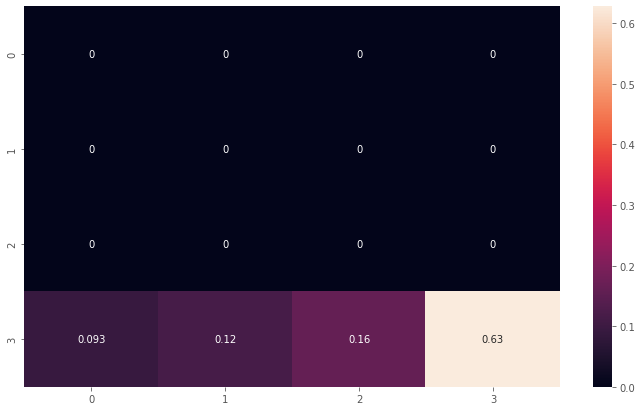

In [ ]:
import seaborn as sn
classes = ('anger', 'joy', 'neutral', 'surprise', 'disgust',
        'saddness', 'fear')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print (cf_matrix)
#df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) , index = [i for i in classes],
                    # columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix/(i+1), annot=True)

In [ ]:
plot_df.head()

,anger_c,joy_c,neutral_c,surprise_c,disgust_c,sadness_c,fear_c
0,2.330415e-15,0.892882,1.071176e-01,3.499367e-16,1.048515e-15,7.258841e-14,2.711066e-21
0,3.913719e-20,0.189076,8.109242e-01,1.634175e-16,1.574137e-18,5.647541e-15,1.372862e-24
0,2.974672e-15,0.344380,6.556124e-01,2.050712e-12,8.652888e-17,7.454042e-06,2.569233e-22
0,1.572771e-22,1.000000,4.252432e-07,1.235683e-23,5.544162e-23,6.795479e-12,1.534819e-32
0,1.877527e-15,0.886700,1.132995e-01,2.901120e-13,1.413621e-20,1.536541e-13,2.223348e-24


In [ ]:
plot_df = plot_df.reset_index()

In [ ]:
plot_df = plot_df.drop("index",axis=1)
plot_df.head()

,anger_c,joy_c,neutral_c,surprise_c,disgust_c,sadness_c,fear_c
0,2.330415e-15,0.892882,1.071176e-01,3.499367e-16,1.048515e-15,7.258841e-14,2.711066e-21
1,3.913719e-20,0.189076,8.109242e-01,1.634175e-16,1.574137e-18,5.647541e-15,1.372862e-24
2,2.974672e-15,0.344380,6.556124e-01,2.050712e-12,8.652888e-17,7.454042e-06,2.569233e-22
3,1.572771e-22,1.000000,4.252432e-07,1.235683e-23,5.544162e-23,6.795479e-12,1.534819e-32
4,1.877527e-15,0.886700,1.132995e-01,2.901120e-13,1.413621e-20,1.536541e-13,2.223348e-24


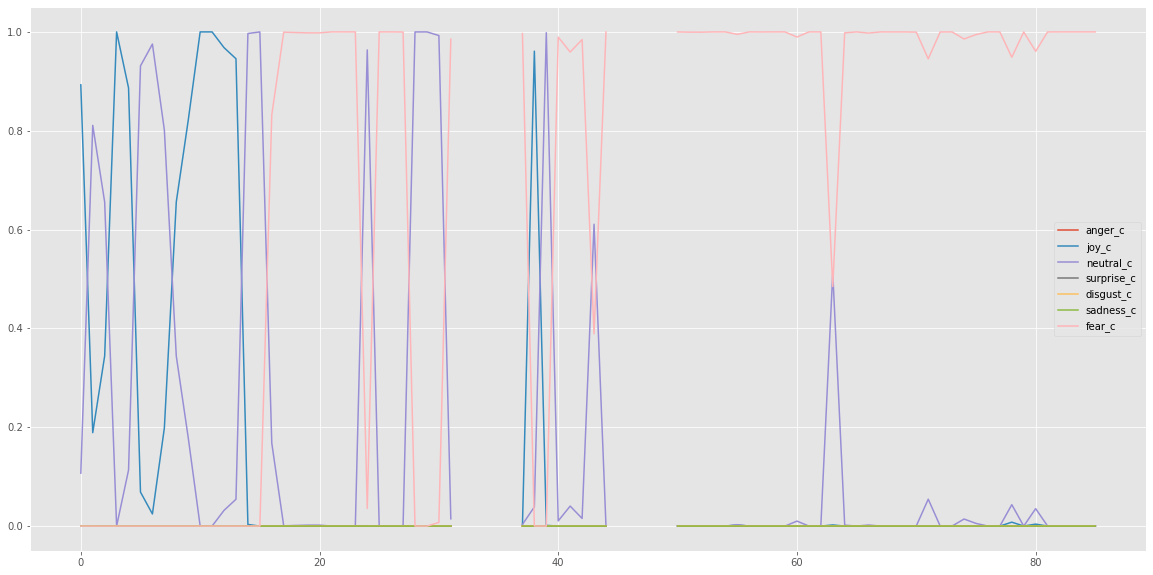

In [ ]:
plot_df.plot(figsize=(20, 10))

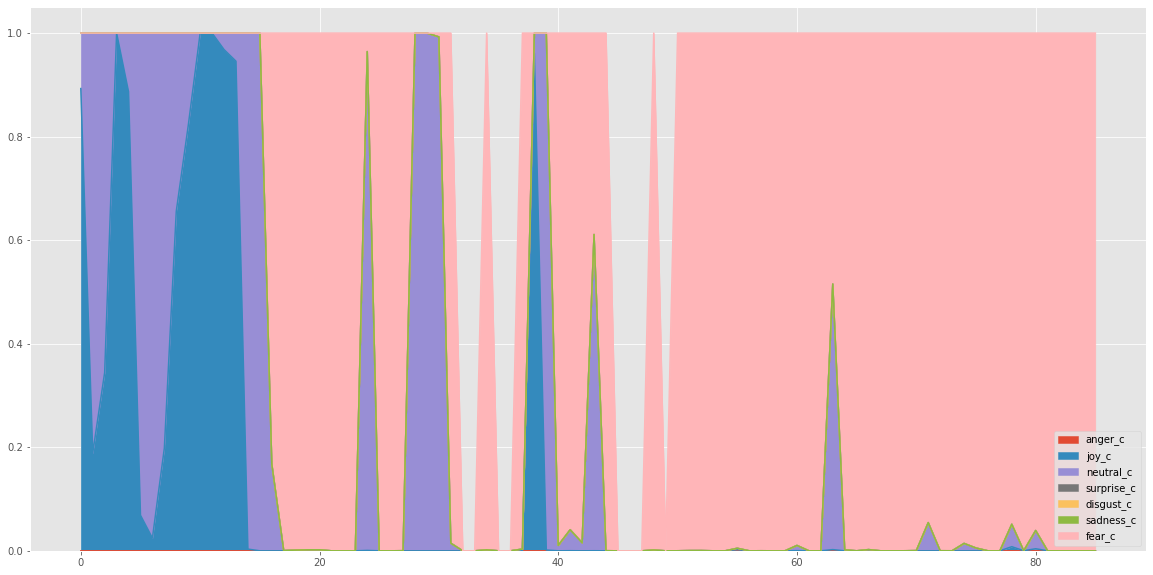

In [ ]:
plot_df.plot(kind='area',figsize=(20, 10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe602695390>,
      dtype=object)

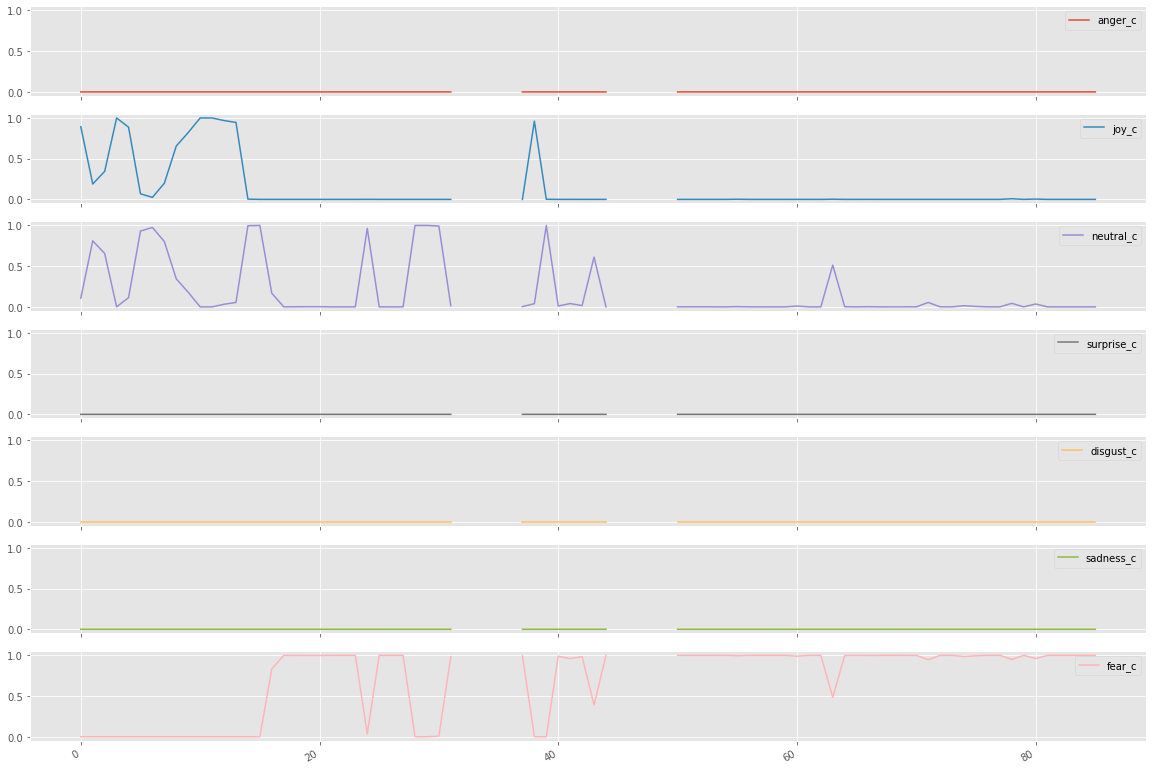

In [ ]:
plot_df.plot(subplots=True, sharey=True,figsize=(20, 15))